Before you run this notebook makesure you have tensorflow is installed on your machine. 
This code is tested on a Macbook Pro with Apple M2 Max. 

In [ ]:
# !!! pip install opencv-python

In [8]:
import tensorflow as tf
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import cv2 as cv
import os
from sklearn.metrics import classification_report

In [11]:
# helper method to load Fashion-MINST data 

def load_minst(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [12]:
# load fashion-mnist data
xx_test, yy_test = load_minst('data/fashion', kind='t10k')
x_train, y_train = load_minst('data/fashion', kind='train')

In [15]:
# load saved tf model and test the accuracy on fashion-mnist test data
tf_model = tf.keras.models.load_model('saved_model/tf_model')

# tf needs data preprocessing as follows before passing

img_rows, img_cols = 28,28
x_test = xx_test.reshape(xx_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std

test_predictions = np.argmax(tf_model.predict(x_test), axis=-1)
print('generating classification report.....')
print(classification_report(yy_test,test_predictions))

313/313 [==============================] - 1s 3ms/step
generating classification report.....
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.89      0.87      1000
           3       0.91      0.92      0.91      1000
           4       0.86      0.87      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.79      0.76      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [16]:
# load saved xg model and test the accuracy on fashion-mnist test data
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("saved_model/xgb_model.bin")

pred = xgb_model.predict(xx_test)
print('generating classification report for xgb_clf_three')
print(classification_report(yy_test,pred))

generating classification report for xgb_clf_three
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.70      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# noticed the two models performes almost the same

In [17]:
# lets build a custom set of test images similar to fashion-minst to evaluated the peformance
# I have gattered 10 images you may add additional test images but make sure you add the labels too.

test_plt_images = list()
test_images = list()
directory = './data/tests'
 
# iterate over files in
# TODO: add credits for the conversion
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    # you may add additonal checks
    if os.path.isfile(f):
        image = cv.imread(f, cv.IMREAD_GRAYSCALE)
        image = cv.resize(image, (28, 28))
        image = image.astype('float32')
        image = 255-image
        test_plt_images.append(image)
        tf_image = image.reshape(1, 28, 28, 1)
        test_images.append(tf_image)
test_plt_images = np.array(test_plt_images)
test_images = np.array(test_images)
true_label = np.array([8,9,8,9,5,7,0,2,2,3])
# review the lists lenghths
print("test images list len:",len(test_images), "test label list len:", len(true_label) )

test images list len: 10 test label list len: 10


In [20]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# helper method for us to visualize the results
def plot_image(i, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  tf_image = img.reshape(1, 28, 28, 1)
  predictions_array = tf_model.predict(tf_image)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  im = img.reshape(1,784)
  xgb_prediction = xgb_model.predict(im)
  color = 'blue'
  plt.xlabel("tf:{}\n xgb:{}\n actual:{}".format(class_names[predicted_label],
                                class_names[xgb_prediction[0]],
                                class_names[true_label]),
                                color=color)

1/1 [==============================] - 0s 12ms/step


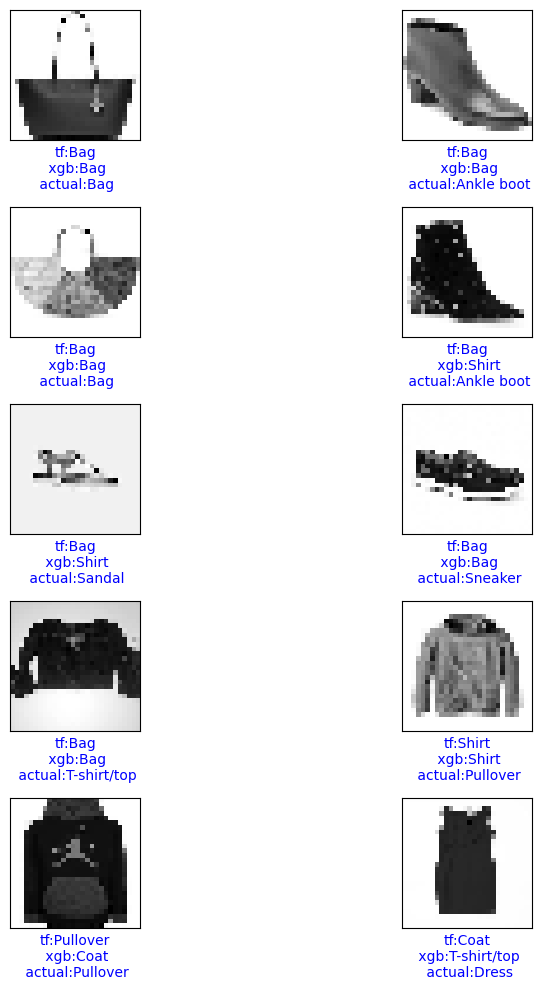

In [21]:
# lets set up a table to view the output

num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, true_label, test_plt_images)
plt.tight_layout()
plt.show()

In [ ]:
# See my paper "Evaluation of the Fashion-MINST Database Using Ensemble-based XGBoost and Neural Network-based TensorFlow Models" for detailed analysis at (the journal url is coming soon)